điiều chỉnh ở phần data valid và data test == nhau

In [6]:
# 📚 Import thư viện
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess_input

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

IMG_SIZE = 224
BATCH_SIZE = 32

# Dùng ImageDataGenerator cho train
train_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    '../../../Bai_4/data_dark/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Load toàn bộ test ảnh
test_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess_input,
)

full_test_generator = test_datagen.flow_from_directory(
    '../../../Bai_4/data_dark/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Tải toàn bộ ảnh test ra numpy array
test_images = []
test_labels = []

for i in range(len(full_test_generator)):
    x, y = full_test_generator[i]
    test_images.append(x[0])
    test_labels.append(y[0])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Chia đôi test thành val và test
X_val, X_test, y_val, y_test = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=42, stratify=test_labels
)

# Tạo generator từ numpy
val_generator = test_datagen.flow(
    X_val, y_val, batch_size=1, shuffle=False
)

test_generator = test_datagen.flow(
    X_val, y_val, batch_size=1, shuffle=False
)
print(f"Tổng số ảnh train: {train_generator.n}")
print(f"Tổng số ảnh val: {val_generator.n}")
print(f"Tổng số ảnh test: {test_generator.n}")

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Tổng số ảnh train: 28709
Tổng số ảnh val: 3589
Tổng số ảnh test: 3589


In [3]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV3Small

# Base model
base_model = MobileNetV3Small(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Functional API
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(7, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,021,687 (3.90 MB)

 Trainable params: 670,759 (2.56 MB)

 Non-trainable params: 350,928 (1.34 MB)

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 253s 276ms/step - accuracy: 0.4113 - loss: 1.5368 - val_accuracy: 0.4731 - val_loss: 1.4378
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 235s 262ms/step - accuracy: 0.5620 - loss: 1.1998 - val_accuracy: 0.4244 - val_loss: 1.6407
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 273s 304ms/step - accuracy: 0.5954 - loss: 1.0895 - val_accuracy: 0.5846 - val_loss: 1.1619
Epoch 4/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 247s 275ms/step - accuracy: 0.6347 - loss: 0.9918 - val_accuracy: 0.5993 - val_loss: 1.1334
Epoch 5/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 221s 246ms/step - accuracy: 0.6598 - loss: 0.9117 - val_accuracy: 0.5929 - val_loss: 1.1460
Epoch 6/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 229s 255ms/step - accuracy: 0.6951 - loss: 0.8357 - val_accuracy: 0.6049 - val_loss: 1.0914
Epoch 7/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 211s 235ms/step - accuracy: 0.7366 - loss: 0.7337 - val_accuracy: 0.6116 - val_loss: 1.1044
Epoch 8/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 209s 233ms/step - accuracy: 0.7608 -

3589/3589 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - accuracy: 0.5889 - loss: 1.1291
Test Accuracy: 60.49%
3589/3589 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step


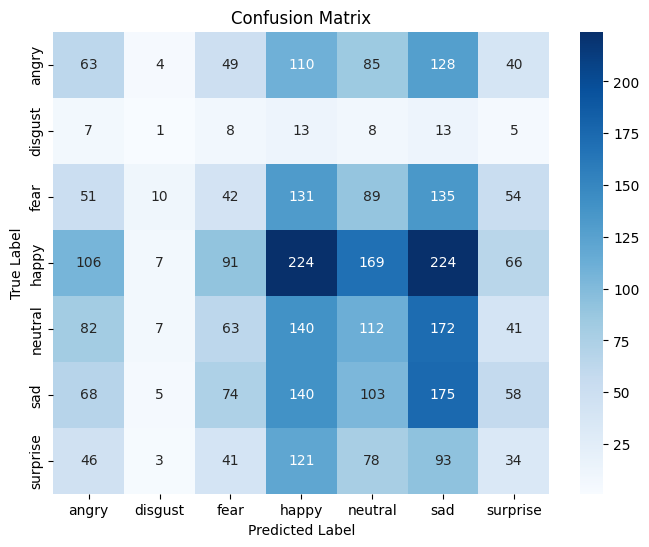

In [16]:
# Accuracy
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Confusion Matrix
y_true = np.argmax(y_test, axis=1)
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Nếu cần lấy label names
class_labels = list(full_test_generator.class_indices.keys())

# Vẽ confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [9]:
model.save("mobilenetv3_fer2013_low_light_V3.keras")  # lưu đúng định dạng mới
size_mb = os.path.getsize("mobilenetv3_fer2013_low_light_V3.keras") / (1024 * 1024)
print(f"Model Size: {size_mb:.2f} MB")

Model Size: 9.59 MB


In [14]:
from sklearn.metrics import f1_score

# F1-Score macro (trung bình đều các lớp)
f1_macro = f1_score(y_true, y_pred_classes, average='macro')

# F1-Score micro (toàn bộ TP, FP, FN gộp lại)
f1_micro = f1_score(y_true, y_pred_classes, average='micro')

# F1-Score weighted (có tính đến số lượng mẫu từng lớp)
f1_weighted = f1_score(y_true, y_pred_classes, average='weighted')

print(f"F1-Score (Macro): {f1_macro * 100:.2f}%")
print(f"F1-Score (Micro): {f1_micro * 100:.2f}%")
print(f"F1-Score (Weighted): {f1_weighted * 100:.2f}%")

F1-Score (Macro): 14.39%
F1-Score (Micro): 18.14%
F1-Score (Weighted): 17.57%


In [13]:
# Inference Time
import time
start = time.time()
_ = model.predict(test_generator)
end = time.time()

inference_time = (end - start) / len(X_test) * 1000  # ms per image
print(f"Average Inference Time: {inference_time:.2f} ms/image")

3589/3589 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step
Average Inference Time: 12.78 ms/image
